# Notebook to calculate P_x

In [1]:
import h5py
import numpy as np
import os
from matplotlib import pyplot as plt

## Read the data from both files

In [2]:
# specify the path to the two files with Lyman alpha skewers, with (ON) and without (OFF) self-shielding 
fname_off='/data/desi/common/astrid/spectra_ASTRID_self-shield_off_z2.5_500x500x2500.hdf5'
fname_on='/data/desi/common/astrid/spectra_ASTRID_z2.5_500x500x2500.hdf5'

In [3]:
with h5py.File(fname_on,'r') as f:
    tau_on = f['tau/H/1/1215'][:]
    colden = f['colden']['H/1'][:]
    axes = f['spectra/axes'][:]
    # (x,y,z) start of the skewers, in kpc/h
    cofm_hkpc = f['spectra/cofm'][:]

In [4]:
with h5py.File(fname_off,'r') as f:
    tau_off = f['tau/H/1/1215'][:]
    # column densities were not stored for this file (should be the same as in the other file)
    #colden_off = f['colden']['H/1'][:]
    axes_off = f['spectra/axes'][:]
    cofm_off = f['spectra/cofm'][:]

In [5]:
# Constants
save_path = '/data/desi/scratch/jlopez/'
Nsk = 500
Np = 2500
block_grid_size = 5
block_size = Nsk // block_grid_size  # = 100
L_hMpc = 250
dz_hMpc=L_hMpc/Np
dxy_hMpc=L_hMpc/Nsk  # = 0.5 Mpc/h

## Break down the simulation into 25 boxes

In [6]:
D2tau_on = tau_on.reshape([Nsk, Nsk, Np])
D2tau_off = tau_off.reshape([Nsk, Nsk, Np])

In [7]:
D2tau_on_blocks = np.empty((block_grid_size, block_grid_size, block_size, block_size, Np))
tau_on_blocks = np.empty((block_grid_size, block_grid_size, block_size**2, Np))

for i in range(block_grid_size):
    for j in range(block_grid_size):
        row_start = i * block_size
        row_end   = (i + 1) * block_size
        col_start = j * block_size
        col_end   = (j + 1) * block_size

        block = D2tau_on[row_start:row_end, col_start:col_end, :]
        D2tau_on_blocks[i, j] = block
        tau_on_blocks[i, j] = block.reshape(block_size**2, Np)

In [8]:
D2tau_off_blocks = np.empty((block_grid_size, block_grid_size, block_size, block_size, Np))
tau_off_blocks = np.empty((block_grid_size, block_grid_size, block_size**2, Np))

for i in range(block_grid_size):
    for j in range(block_grid_size):
        row_start = i * block_size
        row_end   = (i + 1) * block_size
        col_start = j * block_size
        col_end   = (j + 1) * block_size

        block = D2tau_off[row_start:row_end, col_start:col_end, :]
        D2tau_off_blocks[i, j] = block
        tau_off_blocks[i, j] = block.reshape(block_size**2, Np)

In [9]:
for i in range(block_grid_size):
    for j in range(block_grid_size):
        filename = f'tau_on{i}{j}.npy'
        full_path = save_path + filename

        np.save(full_path, tau_on_blocks[i, j])

In [10]:
for i in range(block_grid_size):
    for j in range(block_grid_size):
        filename = f'tau_off{i}{j}.npy'
        full_path = save_path + filename

        np.save(full_path, tau_off_blocks[i, j])

### Checkpoint

In [1]:
import numpy as np
import os
from matplotlib import pyplot as plt

In [2]:
# Constants
save_path = '/data/desi/scratch/jlopez/'
Nsk = 500
Np = 2500
block_grid_size = 5
block_size = Nsk // block_grid_size  # = 100
L_hMpc = 250
dz_hMpc=L_hMpc/Np
dxy_hMpc=L_hMpc/Nsk  # = 0.5 Mpc/h

In [3]:
# Define 4 radial bins (in Mpc/h)
r_edges = np.array([0, 0.6, 0.8, 1.2, 1.6])  # 5 edges → 4 bins
r_edges_pix = r_edges / dxy_hMpc  # convert to pixel units

In [4]:
# Function to load all tau blocks
def load_all_tau_blocks(save_path, block_grid_size=5, block_size=100, Np=2500):
    tau_on_blocks = np.empty((block_grid_size, block_grid_size, block_size**2, Np))
    tau_off_blocks = np.empty((block_grid_size, block_grid_size, block_size**2, Np))
    for i in range(block_grid_size):
        for j in range(block_grid_size):
            tau_on_blocks[i, j] = np.load(os.path.join(save_path, f'tau_on{i}{j}.npy'))
            tau_off_blocks[i, j] = np.load(os.path.join(save_path, f'tau_off{i}{j}.npy'))
    return tau_on_blocks, tau_off_blocks

In [5]:
# Gaussian-filtered field decomposition
def fields(tau_on, tau_off, r_hMpc=0.3):
    tau_max = np.fmax(tau_on, tau_off)
    tau_hcd = tau_max - tau_off
    k = np.fft.rfftfreq(Np) * 2 * np.pi / (L_hMpc / Np)
    tau_modes = np.fft.rfft(tau_hcd)
    tau_hcd = np.fft.irfft(tau_modes * np.exp(-(r_hMpc * k)**2))
    tau_tot = tau_off + tau_hcd
    return tau_tot, tau_off, tau_hcd

In [6]:
# Convert tau to flux contrast δ_F
def delta_F(tau):
    flux = np.exp(-tau)
    return flux / np.mean(flux, axis=1, keepdims=True) - 1

In [7]:
# Power spectrum sum over skewer pairs in a binary mask
def Px_sum(F1, F2, mask, L_hMpc = 250, Np = 2500):
    i_idx, j_idx = np.where(np.triu(mask, k=1))
    A = F1[i_idx]
    B = F2[j_idx].conj()
    Px = np.sum(A * B, axis=0)
    npairs = len(i_idx)
    if npairs > 0:
        Px /= npairs
        Px = Px * (L_hMpc / Np**2)
    else:
        Px[:] = 0.0
    return Px, npairs

In [8]:
def P1D_sum(F1, F2, L_hMpc = 250, Np = 2500):
    F = F1 * F2.conj() * (L_hMpc / Np**2)
    P1D = np.mean(F, axis=0)
    return P1D

In [9]:
# Coordinate arrays and distance matrix
ix_coords, iy_coords = np.divmod(np.arange(block_size**2), block_size)
dx = ix_coords[:, None] - ix_coords[None, :]
dy = iy_coords[:, None] - iy_coords[None, :]
distance_matrix = np.sqrt(dx**2 + dy**2)

In [10]:
# Load tau data
print("Loading tau blocks...")
tau_on_blocks, tau_off_blocks = load_all_tau_blocks(save_path, block_grid_size, block_size, Np)

Loading tau blocks...


In [10]:
# Main loop over radial bins
for b in range(len(r_edges_pix) - 1):
    rmin = r_edges_pix[b]
    rmax = r_edges_pix[b + 1]
    print(f"Processing radial bin {b+1}: {rmin:.2f} < r < {rmax:.2f} pixels")

    # Define mask for current annulus
    mask = (distance_matrix >= rmin) & (distance_matrix < rmax)

    for i in range(block_grid_size):
        for j in range(block_grid_size):
            tau_on = tau_on_blocks[i, j]
            tau_off = tau_off_blocks[i, j]

            # Fields
            tau_tot, tau_lya, tau_hcd = fields(tau_on, tau_off)
            dF_tot = delta_F(tau_tot)
            dF_lya = delta_F(tau_lya)
            dF_hcd = delta_F(tau_hcd)
            dF_lyahcd = dF_lya * dF_hcd

            # FFTs
            fft_tot = np.fft.fft(dF_tot)
            fft_lya = np.fft.fft(dF_lya)
            fft_hcd = np.fft.fft(dF_hcd)
            fft_lyahcd = np.fft.fft(dF_lyahcd)

            # Px calculations (normalized by number of skewer pairs)
            Px_dict = {}
            Px_dict['Px_F'], _ = Px_sum(fft_tot, fft_tot, mask)
            Px_dict['Px_a'], _ = Px_sum(fft_lya, fft_lya, mask)
            Px_dict['Px_H'], _ = Px_sum(fft_hcd, fft_hcd, mask)
            Px_dict['Px_aH'], _ = Px_sum(fft_lya, fft_hcd, mask)
            tmp, _ = Px_sum(fft_hcd, fft_lya, mask)
            Px_dict['Px_aH'] += tmp

            Px_dict['Px_a3'], _ = Px_sum(fft_lya, fft_lyahcd, mask)
            tmp, _ = Px_sum(fft_lyahcd, fft_lya, mask)
            Px_dict['Px_a3'] += tmp

            Px_dict['Px_H3'], _ = Px_sum(fft_hcd, fft_lyahcd, mask)
            tmp, _ = Px_sum(fft_lyahcd, fft_hcd, mask)
            Px_dict['Px_H3'] += tmp

            Px_dict['Px_p4'], _ = Px_sum(fft_lyahcd, fft_lyahcd, mask)

            # Save results
            for key, Px in Px_dict.items():
                filename = f"{key}_rbin{b+1}_{i}{j}.npy"
                np.save(os.path.join(save_path, filename), Px.real)

print("All radial bins processed.")

Processing radial bin 1: 0.00 < r < 1.20 pixels
Processing radial bin 2: 1.20 < r < 1.60 pixels
Processing radial bin 3: 1.60 < r < 2.40 pixels
Processing radial bin 4: 2.40 < r < 3.20 pixels
All radial bins processed.


In [11]:
for i in range(block_grid_size):
    for j in range(block_grid_size):
        tau_on = tau_on_blocks[i, j]
        tau_off = tau_off_blocks[i, j]

        # Fields
        tau_tot, tau_lya, tau_hcd = fields(tau_on, tau_off)
        dF_tot = delta_F(tau_tot)
        dF_lya = delta_F(tau_lya)
        dF_hcd = delta_F(tau_hcd)
        dF_lyahcd = dF_lya * dF_hcd

        # FFTs
        fft_tot = np.fft.fft(dF_tot)
        fft_lya = np.fft.fft(dF_lya)
        fft_hcd = np.fft.fft(dF_hcd)
        fft_lyahcd = np.fft.fft(dF_lyahcd)

        # P1D calculations
        P1D_dict = {}
        P1D_dict['P1D_F'] = P1D_sum(fft_tot, fft_tot)
        P1D_dict['P1D_a'] = P1D_sum(fft_lya, fft_lya)
        P1D_dict['P1D_H'] = P1D_sum(fft_hcd, fft_hcd)
        P1D_dict['P1D_aH'] = P1D_sum(fft_lya, fft_hcd)
        tmp = P1D_sum(fft_hcd, fft_lya)
        P1D_dict['P1D_aH'] += tmp

        P1D_dict['P1D_a3'] = P1D_sum(fft_lya, fft_lyahcd)
        tmp = P1D_sum(fft_lyahcd, fft_lya)
        P1D_dict['P1D_a3'] += tmp

        P1D_dict['P1D_H3'] = P1D_sum(fft_hcd, fft_lyahcd)
        tmp = P1D_sum(fft_lyahcd, fft_hcd)
        P1D_dict['P1D_H3'] += tmp

        P1D_dict['P1D_p4'] = P1D_sum(fft_lyahcd, fft_lyahcd)

        # Save results
        for key, P1D in P1D_dict.items():
            filename = f"{key}_{i}{j}.npy"
            np.save(os.path.join(save_path, filename), P1D.real)

In [19]:
C = np.empty((block_grid_size, block_grid_size))
F_tot = np.empty((block_grid_size, block_grid_size))
F_lya = np.empty((block_grid_size, block_grid_size))
F_hcd = np.empty((block_grid_size, block_grid_size))

for i in range(block_grid_size):
    for j in range(block_grid_size):
        tau_on = tau_on_blocks[i, j]
        tau_off = tau_off_blocks[i, j]
        tau_tot, tau_lya, tau_hcd = fields(tau_on, tau_off)

        # Compute fluxes
        flux_tot = np.exp(-tau_tot)
        flux_lya = np.exp(-tau_lya)
        flux_hcd = np.exp(-tau_hcd)

        # Compute means
        avg_tot = np.mean(flux_tot)
        avg_lya = np.mean(flux_lya)
        avg_hcd = np.mean(flux_hcd)

        # Store result
        C[i, j] = avg_tot / (avg_lya * avg_hcd) - 1
        F_tot[i, j] = avg_tot
        F_lya[i, j] = avg_lya
        F_hcd[i, j] = avg_hcd

# Final average
F_lya_avg = np.mean(F_lya, keepdims=True)
F_hcd_avg = np.mean(F_hcd, keepdims=True)
F_tot_avg = np.mean(F_tot, keepdims=True)
C_1 = C * (F_lya / F_lya_avg) * (F_hcd / F_hcd_avg)
Cavg = np.mean(C_1)
print((np.mean(C) - Cavg) / Cavg)

0.0017228051038779037


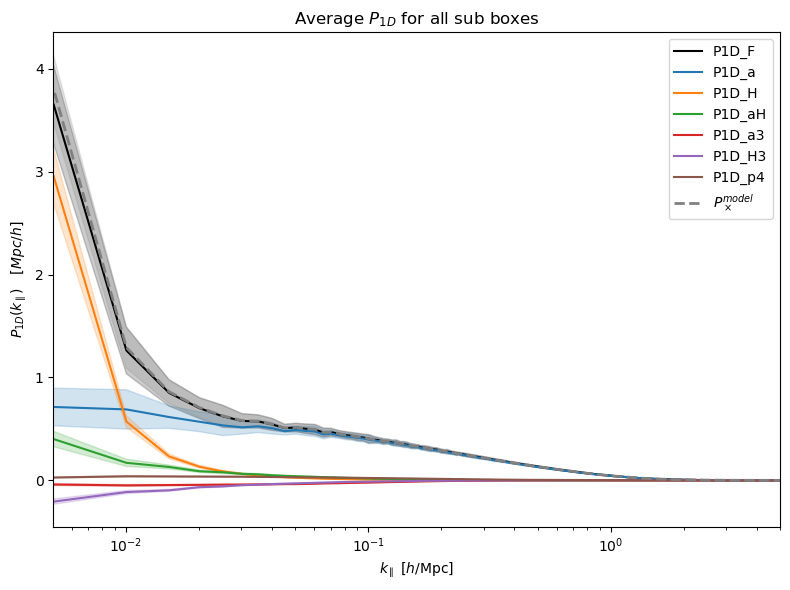

In [15]:
n_blocks = block_grid_size ** 2
k = 2 * np.pi * np.fft.fftfreq(Np, d=dxy_hMpc)
k_positive = k[:Np//2]


keys = ['P1D_F', 'P1D_a', 'P1D_H', 'P1D_aH', 'P1D_a3', 'P1D_H3', 'P1D_p4']
colors = {
    'P1D_F': 'black',
    'P1D_a': 'tab:blue',
    'P1D_H': 'tab:orange',
    'P1D_aH': 'tab:green',
    'P1D_a3': 'tab:red',
    'P1D_H3': 'tab:purple',
    'P1D_p4': 'tab:brown'
}

P1D_all = {key: np.zeros((n_blocks, Np)) for key in keys}
# --- Load ---
for key in keys:
    idx = 0
    for i in range(block_grid_size):
        for j in range(block_grid_size):
            filename = f"{key}_{i}{j}.npy"
            path = os.path.join(save_path, filename)
            if os.path.exists(path):
                P1D_all[key][idx] = np.load(path)
            else:
                print(f"Missing: {filename}")
            idx += 1
# --- Mean, std, and total sum (excluding Px_F) ---
P1D_mean = {}
P1D_std = {}
P1D_sum = np.zeros(Np)
P1D_sum_std = np.zeros(Np)

for key in keys:
    P1D_mean[key] = P1D_all[key].mean(axis=0)
    P1D_std[key] = P1D_all[key].std(axis=0)
    if key != 'P1D_F':
        P1D_sum += P1D_mean[key]
        P1D_sum_std += P1D_std[key]**2  # accumulate variances

P1D_sum_std = np.sqrt(P1D_sum_std)

# --- Plot ---
plt.figure(figsize=(8, 6))

# Plot all components with shaded std
for key in keys:
    plt.plot(k_positive, P1D_mean[key][:Np//2], label=key, color=colors[key])
    plt.fill_between(k_positive,
                     P1D_mean[key][:Np//2] - P1D_std[key][:Np//2],
                     P1D_mean[key][:Np//2] + P1D_std[key][:Np//2],
                     color=colors[key], alpha=0.2)

# Plot sum (excluding P1D_F)
if 'Cavg' not in locals():
    Cavg = 0 
P1D_sum_model = P1D_sum[:Np//2] / (1 + Cavg)**2
P1D_sum_model_std = P1D_sum_std[:Np//2] / (1 + Cavg)**2

plt.plot(k_positive, P1D_sum_model, label=r'$P_\times^{model}$', color='gray', linestyle='--', linewidth=2)
plt.fill_between(k_positive,
                 P1D_sum_model - P1D_sum_model_std,
                 P1D_sum_model + P1D_sum_model_std,
                 color='gray', alpha=0.2)

plt.xlabel(r"$k_{\parallel}$ [$h$/Mpc]")
plt.ylabel(r'$P_{1D}(k_\parallel)\quad[Mpc/h]$')
plt.title(r"Average $P_{1D}$ for all sub boxes")
plt.xscale('log')
plt.xlim(k[1], 5)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


--- Processing bin 1 ---


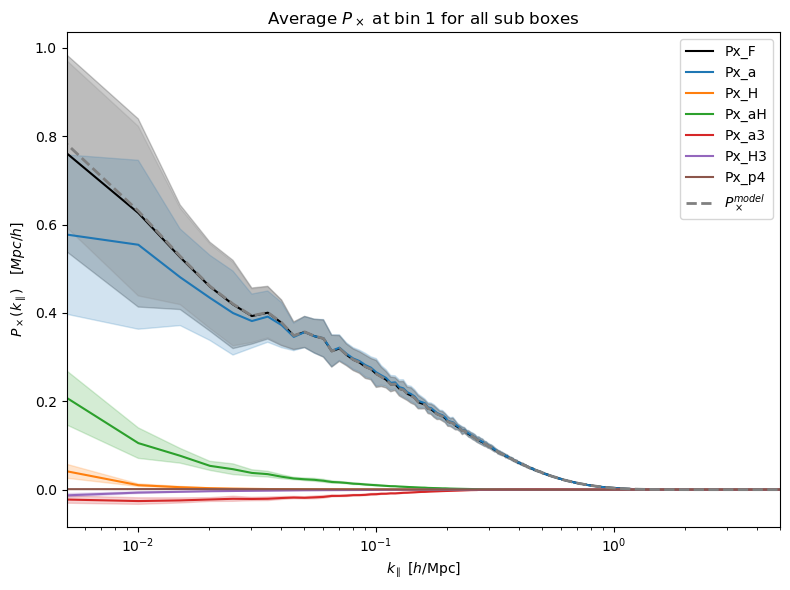


--- Processing bin 2 ---


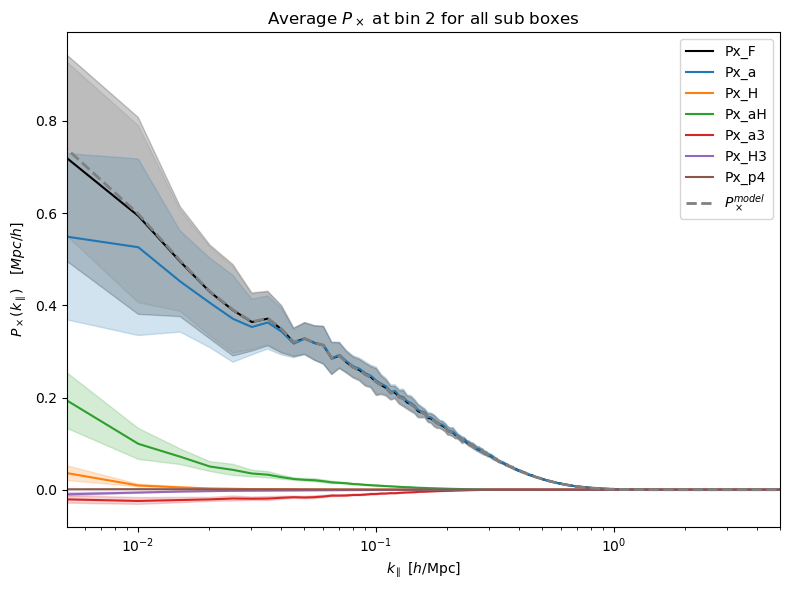


--- Processing bin 3 ---


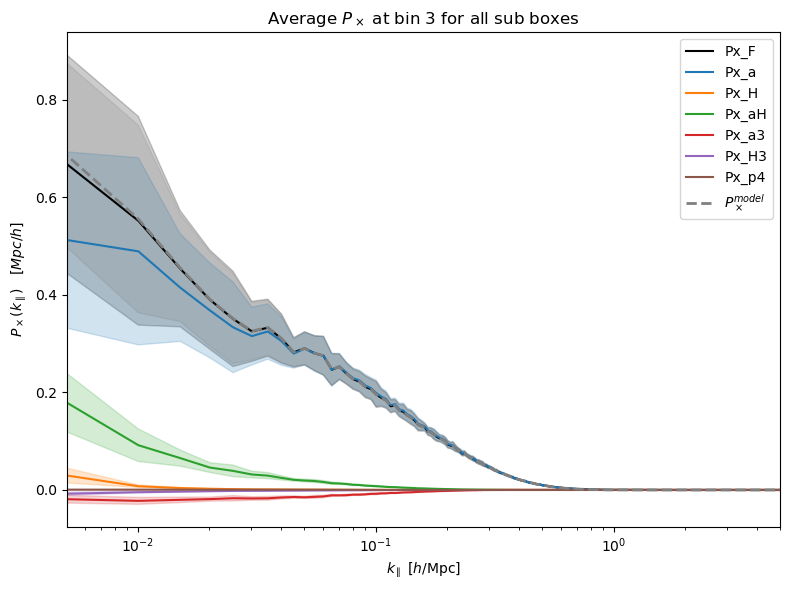


--- Processing bin 4 ---


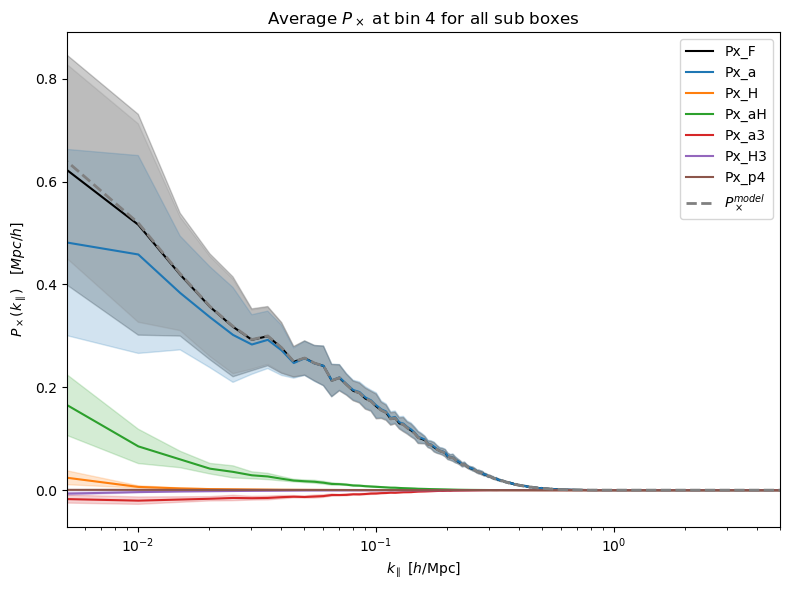

In [16]:
# --- Constants ---
n_blocks = block_grid_size ** 2
bins_to_plot = [1, 2, 3, 4]

# --- FFT positive frequencies ---
k = 2 * np.pi * np.fft.fftfreq(Np, d=dxy_hMpc)
k_positive = k[:Np//2]

# --- Keys to load ---
keys = ['Px_F', 'Px_a', 'Px_H', 'Px_aH', 'Px_a3', 'Px_H3', 'Px_p4']
colors = {
    'Px_F': 'black',
    'Px_a': 'tab:blue',
    'Px_H': 'tab:orange',
    'Px_aH': 'tab:green',
    'Px_a3': 'tab:red',
    'Px_H3': 'tab:purple',
    'Px_p4': 'tab:brown'
}

for bin_number in bins_to_plot:
    print(f"\n--- Processing bin {bin_number} ---")

    # --- Storage ---
    Px_all = {key: np.zeros((n_blocks, Np)) for key in keys}

    # --- Load ---
    for key in keys:
        idx = 0
        for i in range(block_grid_size):
            for j in range(block_grid_size):
                filename = f"{key}_rbin{bin_number}_{i}{j}.npy"
                path = os.path.join(save_path, filename)
                if os.path.exists(path):
                    Px_all[key][idx] = np.load(path)
                else:
                    print(f"Missing: {filename}")
                idx += 1

    # --- Mean, std, and total sum (excluding Px_F) ---
    Px_mean = {}
    Px_std = {}
    Px_sum = np.zeros(Np)
    Px_sum_std = np.zeros(Np)

    for key in keys:
        Px_mean[key] = Px_all[key].mean(axis=0)
        Px_std[key] = Px_all[key].std(axis=0)
        if key != 'Px_F':
            Px_sum += Px_mean[key]
            Px_sum_std += Px_std[key]**2  # accumulate variances

    Px_sum_std = np.sqrt(Px_sum_std)

    # --- Plot ---
    plt.figure(figsize=(8, 6))

    # Plot all components with shaded std
    for key in keys:
        plt.plot(k_positive, Px_mean[key][:Np//2], label=key, color=colors[key])
        plt.fill_between(k_positive,
                         Px_mean[key][:Np//2] - Px_std[key][:Np//2],
                         Px_mean[key][:Np//2] + Px_std[key][:Np//2],
                         color=colors[key], alpha=0.2)

    # Plot sum (excluding Px_F)
    if 'Cavg' not in locals():
        Cavg = 0  # or appropriate default
    Px_sum_model = Px_sum[:Np//2] / (1 + Cavg)**2
    Px_sum_model_std = Px_sum_std[:Np//2] / (1 + Cavg)**2

    plt.plot(k_positive, Px_sum_model, label=r'$P_\times^{model}$', color='gray', linestyle='--', linewidth=2)
    plt.fill_between(k_positive,
                     Px_sum_model - Px_sum_model_std,
                     Px_sum_model + Px_sum_model_std,
                     color='gray', alpha=0.2)

    plt.xlabel(r"$k_{\parallel}$ [$h$/Mpc]")
    plt.ylabel(r'$P_\times(k_\parallel)\quad[Mpc/h]$')
    plt.title(fr"Average $P_\times$ at bin {bin_number} for all sub boxes")
    plt.xscale('log')
    plt.xlim(k[1], 5)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()


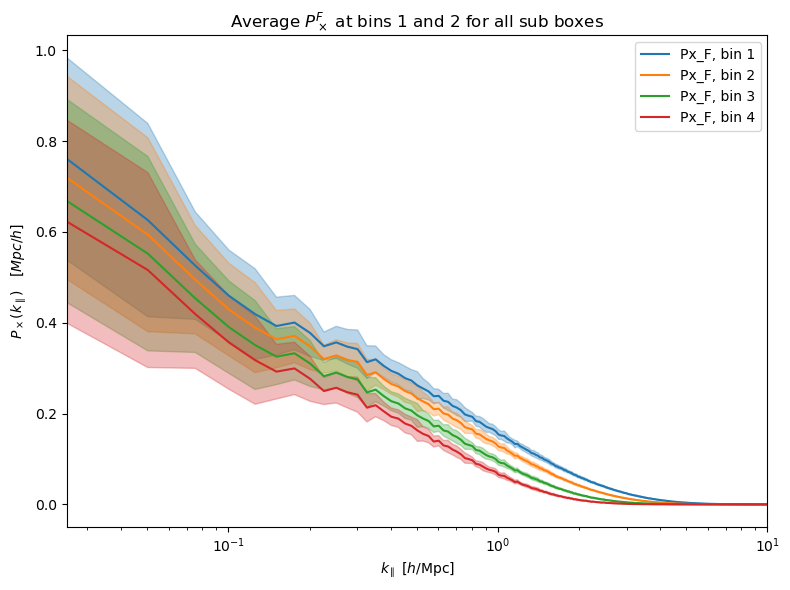

In [26]:
import numpy as np
import os
import matplotlib.pyplot as plt

# --- Constants ---
save_path = '/data/desi/scratch/jlopez/'
block_grid_size = 5
Np = 2500
k = 2 * np.pi / 250 * np.arange(Np)

# --- Which bins to plot ---
bins_to_plot = [1, 2, 3, 4]  # bin indices are 1-based

# --- Load data and compute statistics ---
Px_mean = {}
Px_std = {}

for b in bins_to_plot:
    all_Px = []
    for i in range(block_grid_size):
        for j in range(block_grid_size):
            fname = f'Px_F_rbin{b}_{i}{j}.npy'
            path = os.path.join(save_path, fname)
            if os.path.exists(path):
                Px = np.load(path)
                all_Px.append(Px.real)
    all_Px = np.array(all_Px)
    
    if all_Px.shape[0] == 0:
        print(f"No data found for bin {b}")
        continue

    Px_mean[b] = np.mean(all_Px, axis=0)
    Px_std[b] = np.std(all_Px, axis=0)

# --- Plotting ---
plt.figure(figsize=(8, 6))

colors = ['C0', 'C1', 'C2', 'C3']
for idx, b in enumerate(bins_to_plot):
    mean = Px_mean[b]
    std = Px_std[b]
    label = f'Px_F, bin {b}'

    plt.plot(k[:Np//2], mean[:Np//2], label=label, color=colors[idx])
    #plt.fill_between(k[:Np//2], mean[:Np//2] - std[:Np//2], mean[:Np//2] + std[:Np//2],
                     #color=colors[idx], alpha=0.3)

plt.xlabel(r"$k_{\parallel}$ [$h$/Mpc]")
plt.ylabel(r'$P_\times(k_\parallel)\quad[Mpc/h]$')
plt.title(r"Average $P_\times^F$ at bins 1 to 4 for all sub boxes")
plt.xscale('log')
plt.xlim(k[1], 10)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('PxF')
plt.show()


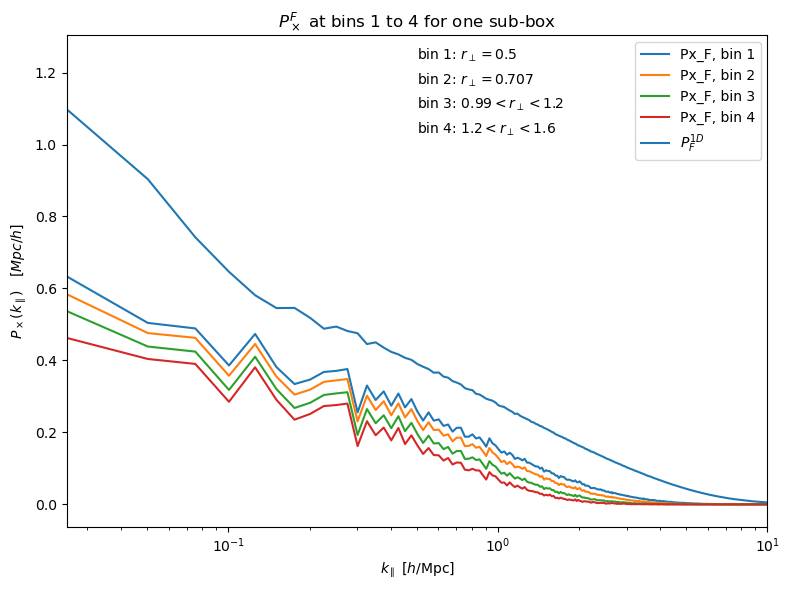

In [22]:
import numpy as np
import os
import matplotlib.pyplot as plt

# --- Constants ---
save_path = '/data/desi/scratch/jlopez/'
block_grid_size = 5
Np = 2500
k = 2 * np.pi / 250 * np.arange(Np)

# --- Which bins to plot ---
bins_to_plot = [1, 2, 3, 4]  # bin indices are 1-based

# --- Load data and compute statistics ---
Px_mean = {}
Px_std = {}

for b in bins_to_plot:
    all_Px = []
    for i in range(1):
        for j in range(1):
            fname = f'Px_F_rbin{b}_{i}{j}.npy'
            path = os.path.join(save_path, fname)
            if os.path.exists(path):
                Px = np.load(path)
                all_Px.append(Px.real)
    all_Px = np.array(all_Px)
    
    if all_Px.shape[0] == 0:
        print(f"No data found for bin {b}")
        continue

    Px_mean[b] = np.mean(all_Px, axis=0)
    Px_std[b] = np.std(all_Px, axis=0)

# --- Plotting ---
plt.figure(figsize=(8, 6))

colors = ['C0', 'C1', 'C2', 'C3']
for idx, b in enumerate(bins_to_plot):
    mean = Px_mean[b]
    std = Px_std[b]
    label = f'Px_F, bin {b}'

    plt.plot(k[:Np//2], mean[:Np//2]/100, label=label, color=colors[idx])
    #plt.fill_between(k[:Np//2], mean[:Np//2] - std[:Np//2], mean[:Np//2] + std[:Np//2],
                     #color=colors[idx], alpha=0.3)
plt.plot(k, P_F.real, label = r'$P^{1D}_{F}$')
plt.xlabel(r"$k_{\parallel}$ [$h$/Mpc]")
plt.ylabel(r'$P_\times(k_\parallel)\quad[Mpc/h]$')
plt.title(r"$P_\times^F$ at bins 1 to 4 for one sub-box")
plt.xscale('log')
plt.xlim(k[1], 10)
plt.text(0.5, 0.95, r'bin 1: $r_\perp = 0.5$', transform = plt.gca().transAxes, fontsize=10)
plt.text(0.5, 0.9, r'bin 2: $r_\perp = 0.707$', transform = plt.gca().transAxes, fontsize=10)
plt.text(0.5, 0.85, r'bin 3: $0.99 < r_\perp < 1.2$', transform = plt.gca().transAxes, fontsize=10)
plt.text(0.5, 0.8, r'bin 4: $1.2 < r_\perp < 1.6$', transform = plt.gca().transAxes, fontsize=10)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('4bins')
plt.show()